# Resource Utilisation Exploratory

**TODOS**

- Extend each plot to `max_time`
- Calculate total utilisation to `max_time` (global) rather than per-resource `max_time`
- Colour code by max capacity

## Setup

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Change directory to submission
os.chdir("../")

In [2]:
%matplotlib inline


# Regular Simulation (3 Hospitals)

### Hospital Usage

The data is in the form of events at simulation times. We can plot the capacity and queue as line graphs with step interpolation at the time points specified in the data. 

The way the data is laid out is with a "delay" - for example, the first row is an event with `event_time` at 1900 minutes, but the capacity and queue at event time reflect the state of the resource *up until that point*. We can therefore shift each of the events for a resource ahead by one (and adding an `event_time` of 0 to the first event) and calculate the last value. Then, we can simply plot `capacity_at_event_time` and `queue_at_event_time` on the y axis, and the `shifted_event_time` on the x-axis. 

First loading the capacity data, which should be the same for all 3hosp simulations.

In [3]:
# Loading the hospital capacity data
# import hospital name and capacity
hospital_data_columns = ["name", "capacity", "acutebedCapacity", "nonacutebedCapacity"]

rural_hospital_data = pd.read_csv(
    "data/internal/hospitalupdate/3hosp/rhosp.csv", names=hospital_data_columns
)
rural_hospital_data["hospital_type"] = "rural"

peripheral_hospital_data = pd.read_csv(
    "data/internal/hospitalupdate/3hosp/pschosp.csv", names=hospital_data_columns
)
peripheral_hospital_data["hospital_type"] = "peripheral"

central_hospital_data = pd.read_csv(
    "data/internal/hospitalupdate/3hosp/cschosp.csv", names=hospital_data_columns
)
central_hospital_data["hospital_type"] = "central"

ecr_capable_hospital_data = pd.read_csv(
    "data/internal/hospitalupdate/3hosp/ecrCapablehosp.csv", names=hospital_data_columns
)

hospital_data = pd.concat(
    [rural_hospital_data, peripheral_hospital_data, central_hospital_data, ecr_capable_hospital_data]
).set_index("name")


# ANGIO CAPACITIES

# Change Alfred to central for angio 
hospital_data.loc[hospital_data.index == "The Alfred", "hospital_type"] = "central"

# Default 1
central_hospitals = hospital_data[hospital_data.hospital_type == "central"].index

angio_dicts = [{"name": hospital, "capacity": hospital_data.acutebedCapacity.loc[hospital]} for hospital in central_hospitals]

angio_capacities = pd.DataFrame.from_records(angio_dicts).set_index("name")

In [4]:
hospital_data

,acutebedCapacity,capacity,hospital_type,nonacutebedCapacity
name,,,,
Albury Wodonga Health,NaN,1,rural,10
Bairnsdale Regional Health,NaN,1,rural,10
Ballarat Health,NaN,1,rural,10
Barwon Health,NaN,1,rural,10
Bendigo Health Care Group,NaN,1,rural,10
Echuca Regional Health,NaN,1,rural,10
Goulburn Valley Health,NaN,1,rural,10
Melton Health,NaN,1,rural,10
Mildura Base Hospital,NaN,1,rural,10


In [5]:
angio_capacities

,capacity
name,
Austin Health,5.0
Monash Health,5.0
Royal Melbourne Hospital,5.0
The Alfred,3.0


Defining a reusable plotting function:

In [6]:
def append_to_series(series, last_value_change):
    return series.append(pd.Series(series.iloc[-1] + last_value_change))

def plot_utilisation_over_time(usage, resource_capacities, resource_type, plot_yticks=False):
    
    n_resources = len(resource_capacities)
    resource_names = set(usage.name)

    fig, axes = plt.subplots(nrows=n_resources, sharex = True)

    for i, resource in enumerate(resource_names):
        subset = usage[usage.name == resource]
        
        # Just use the first 31 days
        subset = subset[subset.event_time < (60 * 24 * 31)]

        ys_capacity = subset.capacity_at_event_time
        ys_queue = subset.queue_at_event_time    
        events = subset.event

        # Calculate last value
        try:
            if events.iloc[-1] == "request":
                if ys_capacity.iloc[-1] == resource_capacities.loc[resource].capacity: # last one is queued
                    ys_capacity = append_to_series(ys_capacity, 0)
                    ys_queue = append_to_series(ys_queue, 1)
                else: # last one is admitted
                    ys_capacity = append_to_series(ys_capacity, 1)
                    ys_queue = append_to_series(ys_queue, 0)
            else:
                if ys_queue.iloc[-1] > 0: # patient was in queue
                    ys_capacity = append_to_series(ys_capacity, 0)
                    ys_queue = append_to_series(ys_queue, -1)
                else:
                    ys_capacity = append_to_series(ys_capacity, -1)
                    ys_queue = append_to_series(ys_queue, 0)
                    
                # Stack capacity and queue
            ys = ys_capacity + ys_queue
            xs = pd.Series([0]).append(subset.event_time)
        except IndexError: # likely no entries
            xs = []
            ys = []



        #axes[i].step(xs, ys, where="post", label="Queue", linewidth=0.05)
        #axes[i].step(xs, ys_capacity, where="post", label="Capacity", linewidth=0.05)
        axes[i].fill_between(xs, ys, step="post", label="Queue", alpha = 0.5)
        axes[i].fill_between(xs, ys_capacity, step="post", label="Capacity", alpha=1)
        #axes[i].bar(xs, ys, label="Queue")
        #axes[i].bar(xs, ys_capacity, label="Capacity")
        axes[i].set_ylim([0, max(usage.capacity_at_event_time) + max(usage.queue_at_event_time)])
        #axes[i].set_xlim([0, max(usage.event_time)])
        axes[i].set_ylabel(resource, rotation=0, labelpad=80)
        
        if not plot_yticks:
            axes[i].set_yticklabels([]) # remove y-tick

        if i == 0:
            axes[i].legend(loc="upper right")
            axes[i].set_title('Capacity and Queue (Stacked) of {} During Simulation (First 31 Days)'.format(resource_type))

    fig.text(0.5, 0.05, 'Simulation Time (minutes)', ha='center')

In [7]:
def plot_total_utilisation(usage, resource_capacities, max_time, resource_type):
    
    n_resources = len(resource_capacities)
    resource_names = set(usage.name)
    
    resource_names_with_capacities = ["{} (max {})".format(resource, resource_capacities.at[resource, "capacity"])
                                     for resource in resource_names]

    totals = []
    for i, resource in enumerate(resource_names):
        subset = usage[usage.name == resource]

        ys_capacity = subset.capacity_at_event_time

        xs = subset.event_time
        
        utilisation = 0
        max_capacity = resource_capacities.at[resource, "capacity"]
        #max_utilisation = max_capacity * max_time
        #max_utilisation = max_capacity * max(xs)
        
        j = 0
        max_utilisation = 0
        for k, capacity in ys_capacity.iteritems():
            if j == 0:
                point_utilisation = 0
                point_max = xs.iloc[0] * max_capacity
            else:
                point_utilisation = (xs.iloc[j] - xs.iloc[j-1]) * capacity
                point_max = (xs.iloc[j] - xs.iloc[j-1]) * max_capacity
            max_utilisation += point_max
            utilisation += point_utilisation
            j += 1
            
        utilisation = utilisation / max_utilisation
        
        # For Alfred specifically, as it is only active for a third of the max time.
        if resource == "The Alfred" and resource_type == "Acute Beds":
            utilisation = utilisation * 3
            
        totals.append(utilisation)
    
    # total_utilisation = pd.DataFrame(totals)
    plt.bar(range(n_resources), totals)
    plt.xticks(range(n_resources), resource_names_with_capacities, rotation=90)
    plt.axhline(np.mean(totals), color="red", linestyle=":")
    plt.title("Total Utilisation (Capacity) as a Proportion of Max Capacity for {}".format(resource_type))

> Note that this is out of total utilisation for the duration of the simulation, except for the Alfred (which operates only a third of the time - its value has been multiplied by 3 to reflect this, so each bar should represent the utilisation as a proportion of the maximum capacity for that resource.)

In [8]:
def make_plots(hospital_usage_file, angio_usage_file):
    
    hospital_usage = pd.read_csv(hospital_usage_file)
    angio_usage = pd.read_csv(angio_usage_file)

    hospitals = set(hospital_usage.name)
    
    plt.figure()
    matplotlib.rcParams['figure.figsize'] = [20, 20]
    plot_utilisation_over_time(hospital_usage, hospital_data, "Codestroke")
    
    plt.figure()
    matplotlib.rcParams['figure.figsize'] = [10, 4]
    plot_utilisation_over_time(angio_usage, angio_capacities, "Acute Beds", plot_yticks=True)
    
    max_time = None # not used for now
    
    plt.figure()
    matplotlib.rcParams['figure.figsize'] = [10, 5]
    plot_total_utilisation(hospital_usage, hospital_data, max_time, "Codestroke")
    
    plt.figure()
    matplotlib.rcParams['figure.figsize'] = [5, 5]
    plot_total_utilisation(angio_usage,
                           angio_capacities,
                           max_time, "Acute Beds")

### ECR 3

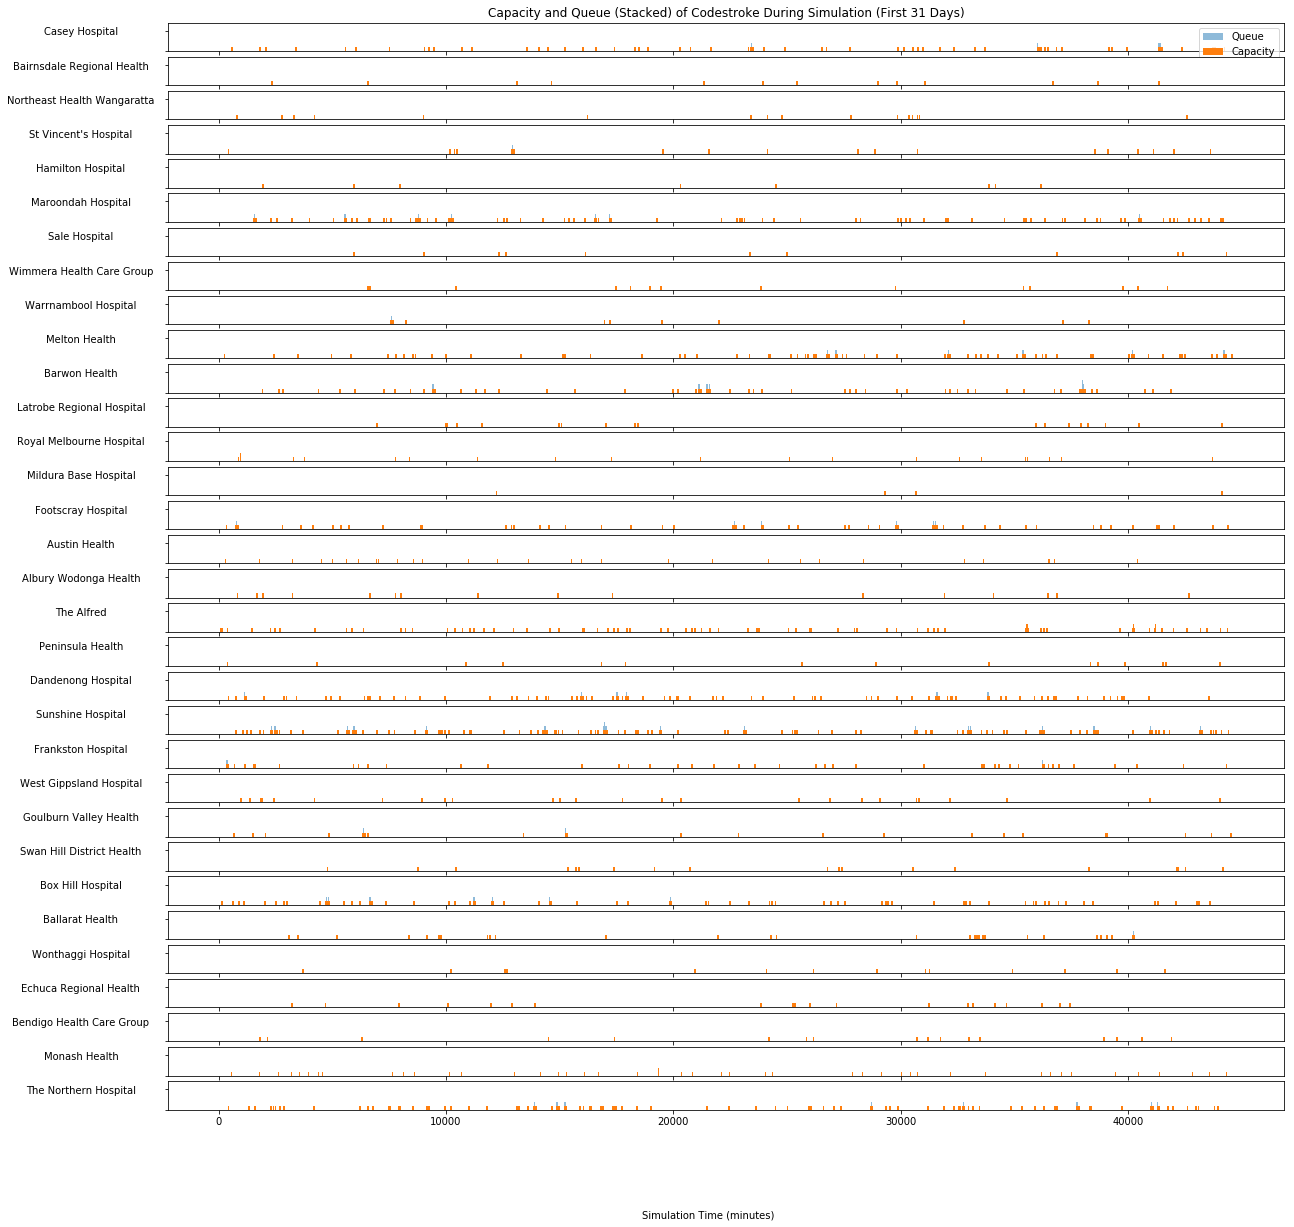

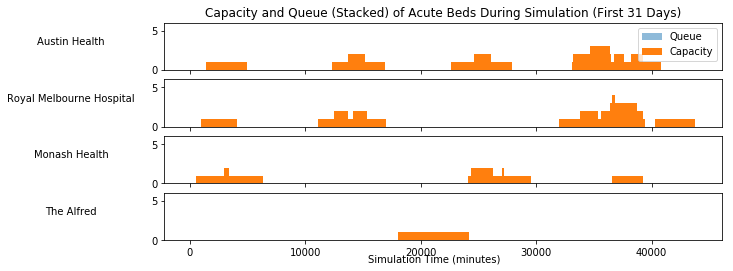

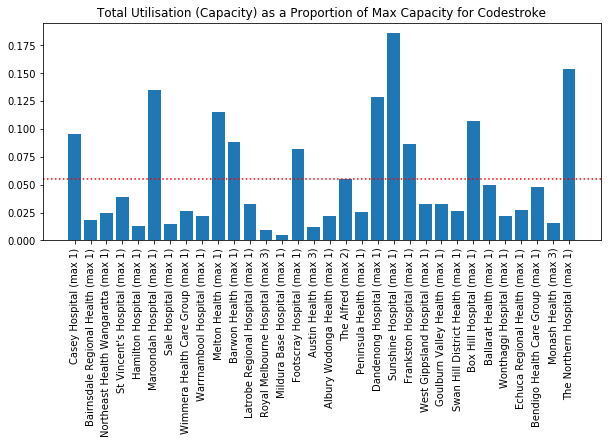

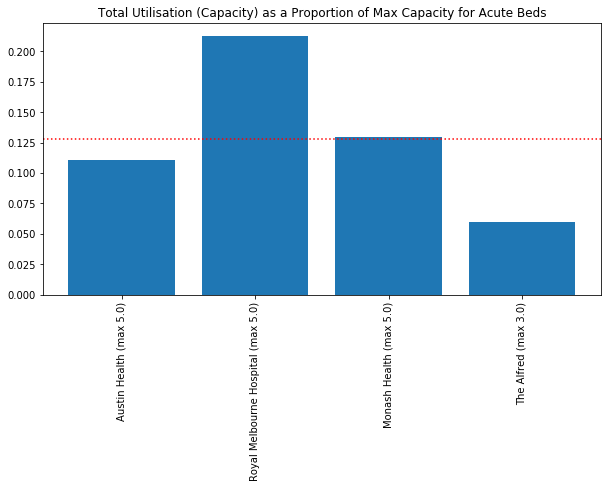

In [9]:
hospital_usage_file = "./data/processed/2019_06_30_0115_3_3hosp_vicsim_codestroke_usage.csv"
angio_usage_file = "./data/processed/2019_06_30_0115_3_3hosp_vicsim_acutebed_usage.csv"
make_plots(hospital_usage_file, angio_usage_file)

### ECR 5

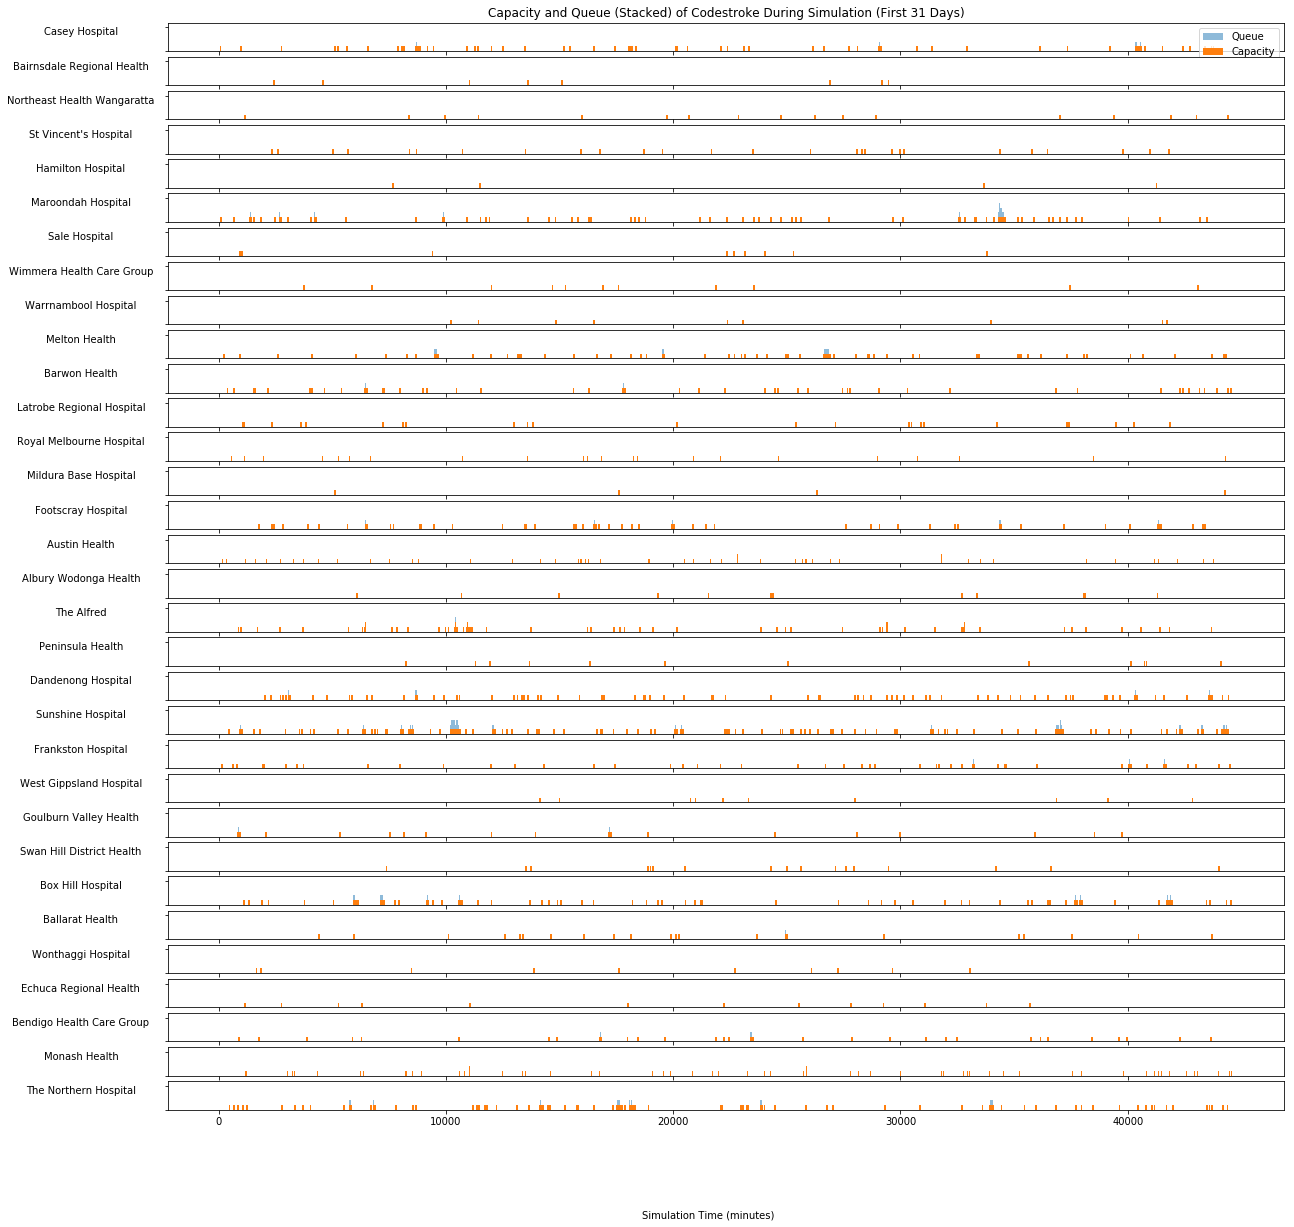

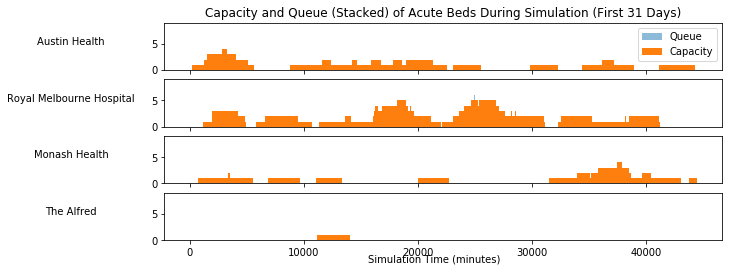

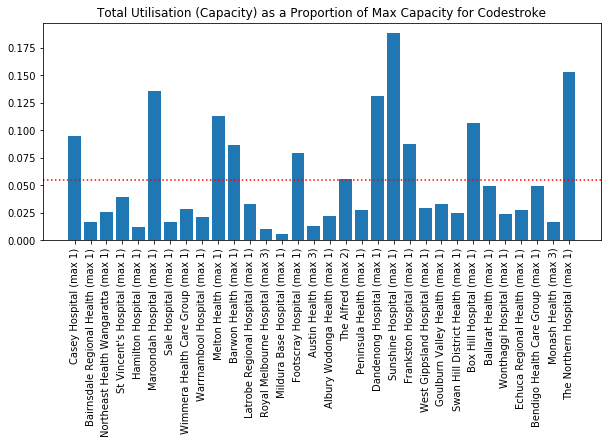

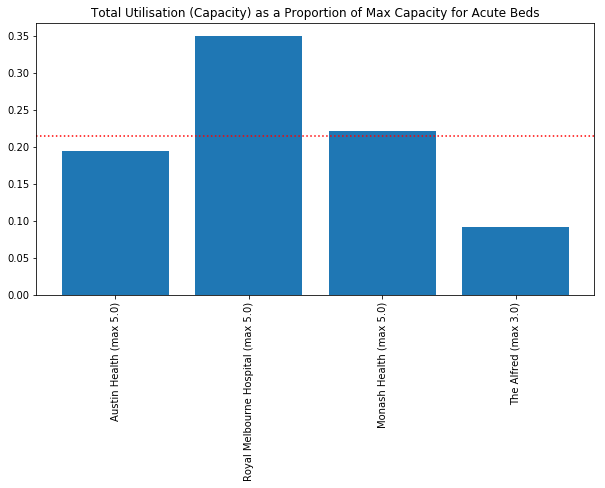

In [10]:
hospital_usage_file = "data/processed/2019_06_30_0120_5_3hosp_vicsim_codestroke_usage.csv"
angio_usage_file = "data/processed/2019_06_30_0120_5_3hosp_vicsim_acutebed_usage.csv"
make_plots(hospital_usage_file, angio_usage_file)

### ECR 10

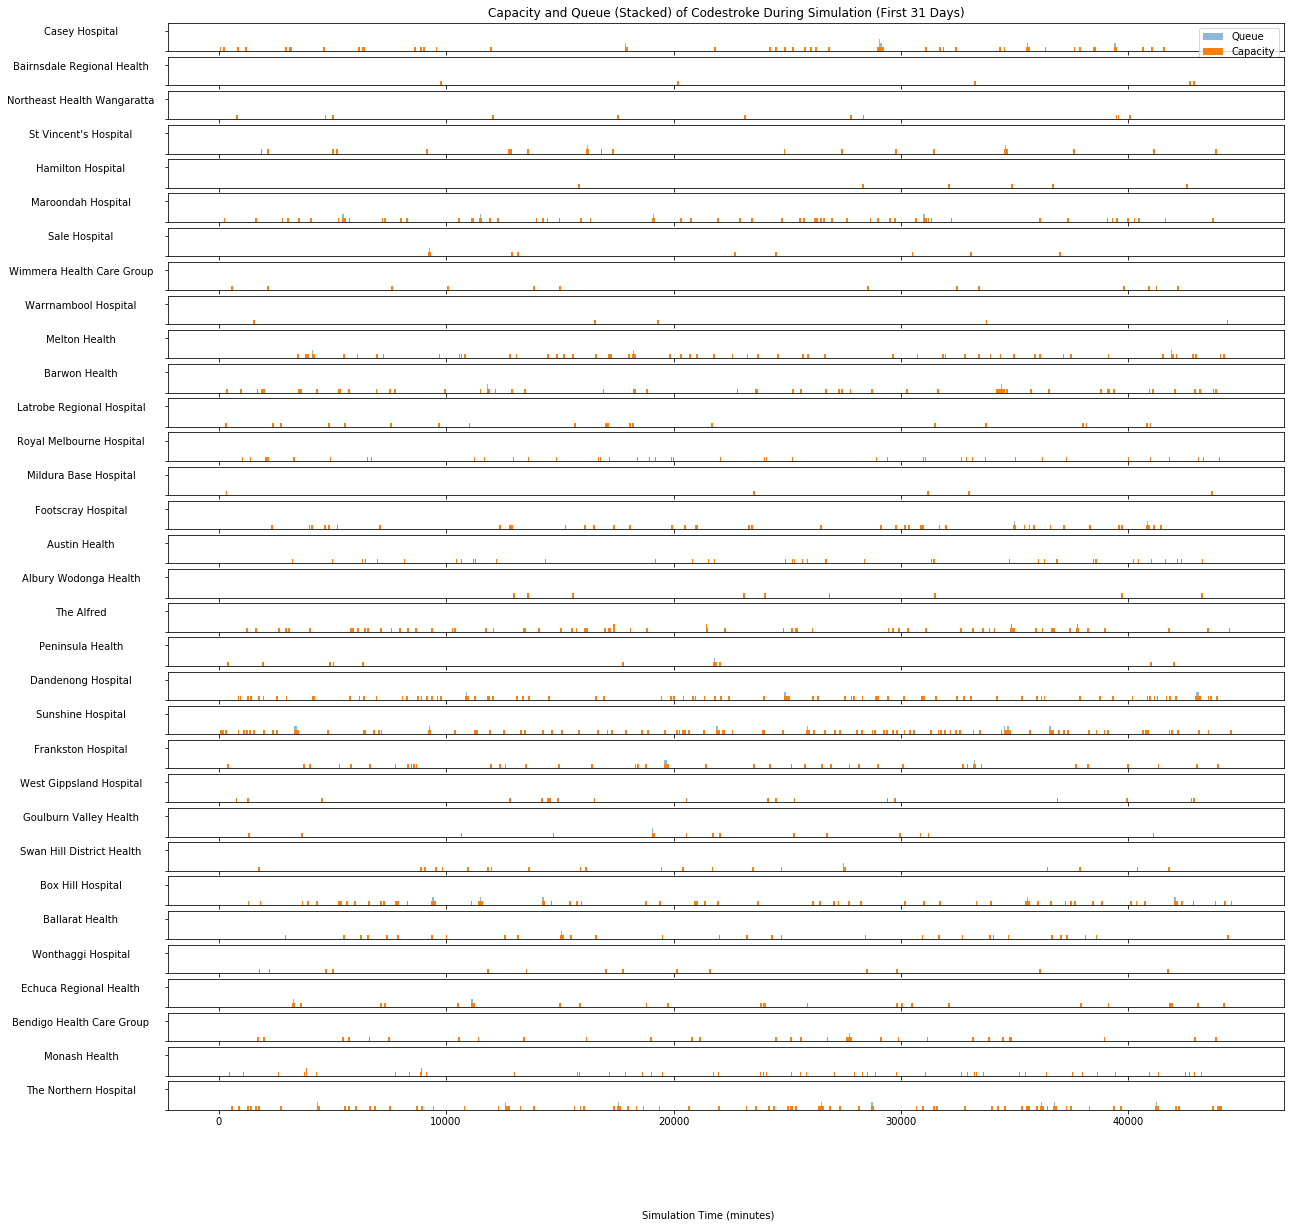

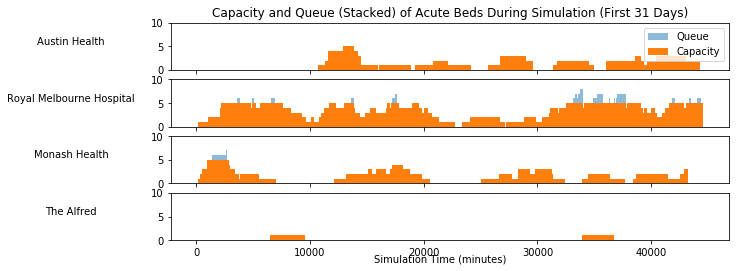

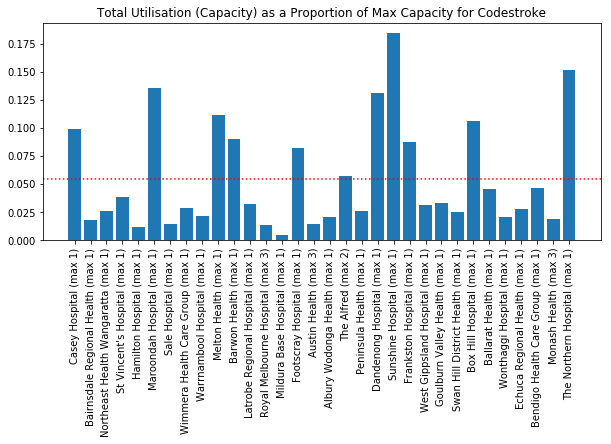

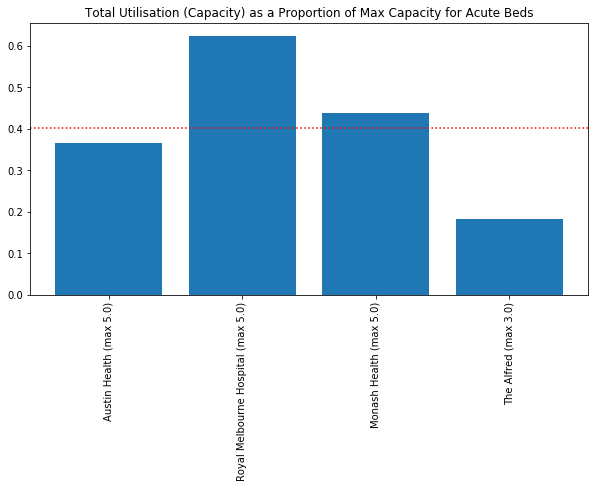

In [11]:
hospital_usage_file = "data/processed/2019_06_30_0125_10_3hosp_vicsim_codestroke_usage.csv"
angio_usage_file = "data/processed/2019_06_30_0125_10_3hosp_vicsim_acutebed_usage.csv"
make_plots(hospital_usage_file, angio_usage_file)

### ECR 15

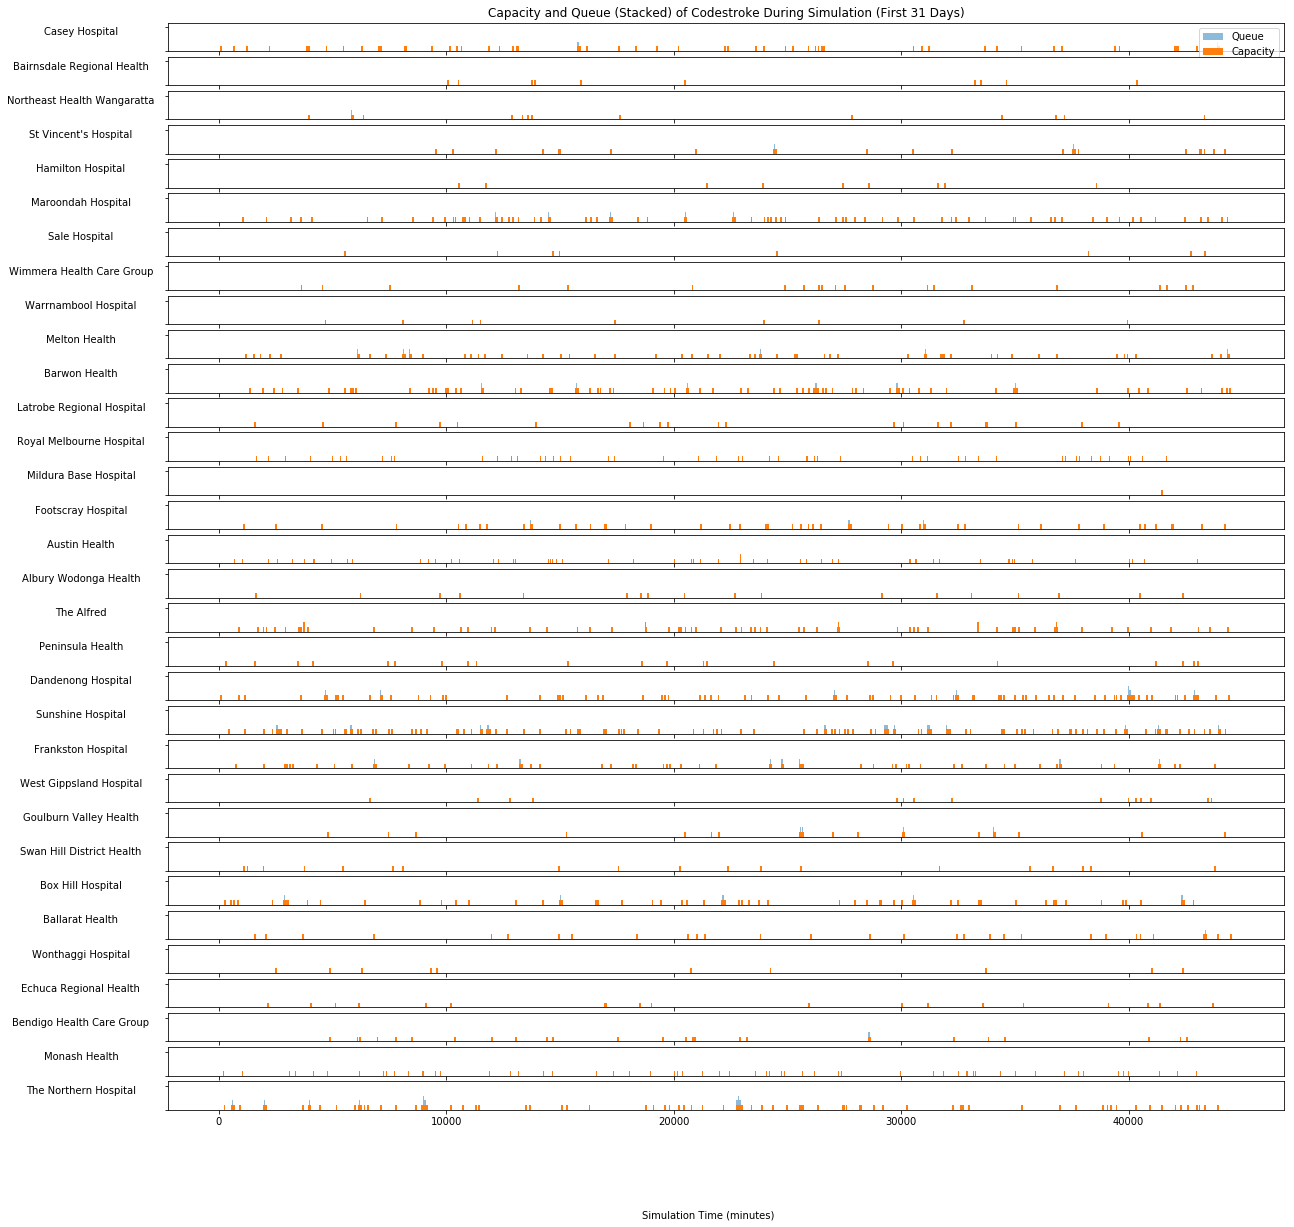

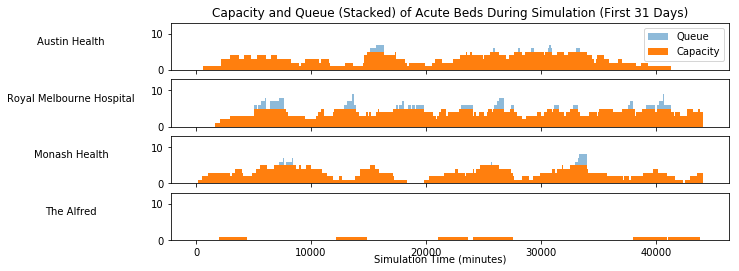

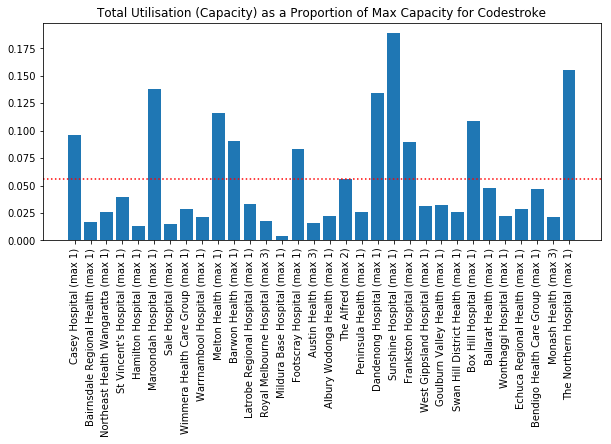

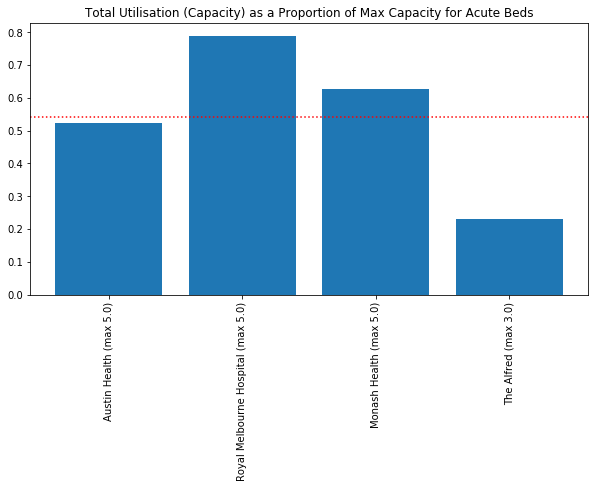

In [12]:
hospital_usage_file = "data/processed/2019_06_30_0130_15_3hosp_vicsim_codestroke_usage.csv"
angio_usage_file = "data/processed/2019_06_30_0130_15_3hosp_vicsim_acutebed_usage.csv"
make_plots(hospital_usage_file, angio_usage_file)

# 2-Hospital Comparison

In [13]:
# Loading the hospital capacity data
# import hospital name and capacity
hospital_data_columns = ["name", "capacity", "acutebedCapacity", "nonacutebedCapacity"]

rural_hospital_data = pd.read_csv(
    "data/internal/hospitalupdate/2hosp/rhosp.csv", names=hospital_data_columns
)
rural_hospital_data["hospital_type"] = "rural"

peripheral_hospital_data = pd.read_csv(
    "data/internal/hospitalupdate/2hosp/pschosp.csv", names=hospital_data_columns
)
peripheral_hospital_data["hospital_type"] = "peripheral"

central_hospital_data = pd.read_csv(
    "data/internal/hospitalupdate/2hosp/cschosp.csv", names=hospital_data_columns
)
central_hospital_data["hospital_type"] = "central"

ecr_capable_hospital_data = pd.read_csv(
    "data/internal/hospitalupdate/2hosp/ecrCapablehosp.csv", names=hospital_data_columns
)

hospital_data = pd.concat(
    [rural_hospital_data, peripheral_hospital_data, central_hospital_data, ecr_capable_hospital_data]
).set_index("name")


# ANGIO CAPACITIES

# Change Alfred to central for angio 
hospital_data.loc[hospital_data.index == "The Alfred", "hospital_type"] = "central"

# Default 1
central_hospitals = hospital_data[hospital_data.hospital_type == "central"].index

angio_dicts = [{"name": hospital, "capacity": hospital_data.acutebedCapacity.loc[hospital]} for hospital in central_hospitals]

angio_capacities = pd.DataFrame.from_records(angio_dicts).set_index("name")

In [14]:
hospital_data

,acutebedCapacity,capacity,hospital_type,nonacutebedCapacity
name,,,,
Albury Wodonga Health,NaN,1,rural,10
Bairnsdale Regional Health,NaN,1,rural,10
Ballarat Health,NaN,1,rural,10
Barwon Health,NaN,1,rural,10
Bendigo Health Care Group,NaN,1,rural,10
Echuca Regional Health,NaN,1,rural,10
Goulburn Valley Health,NaN,1,rural,10
Melton Health,NaN,1,rural,10
Mildura Base Hospital,NaN,1,rural,10


In [15]:
angio_capacities

,capacity
name,
Monash Health,5.0
Royal Melbourne Hospital,5.0
The Alfred,3.0


### ECR 3

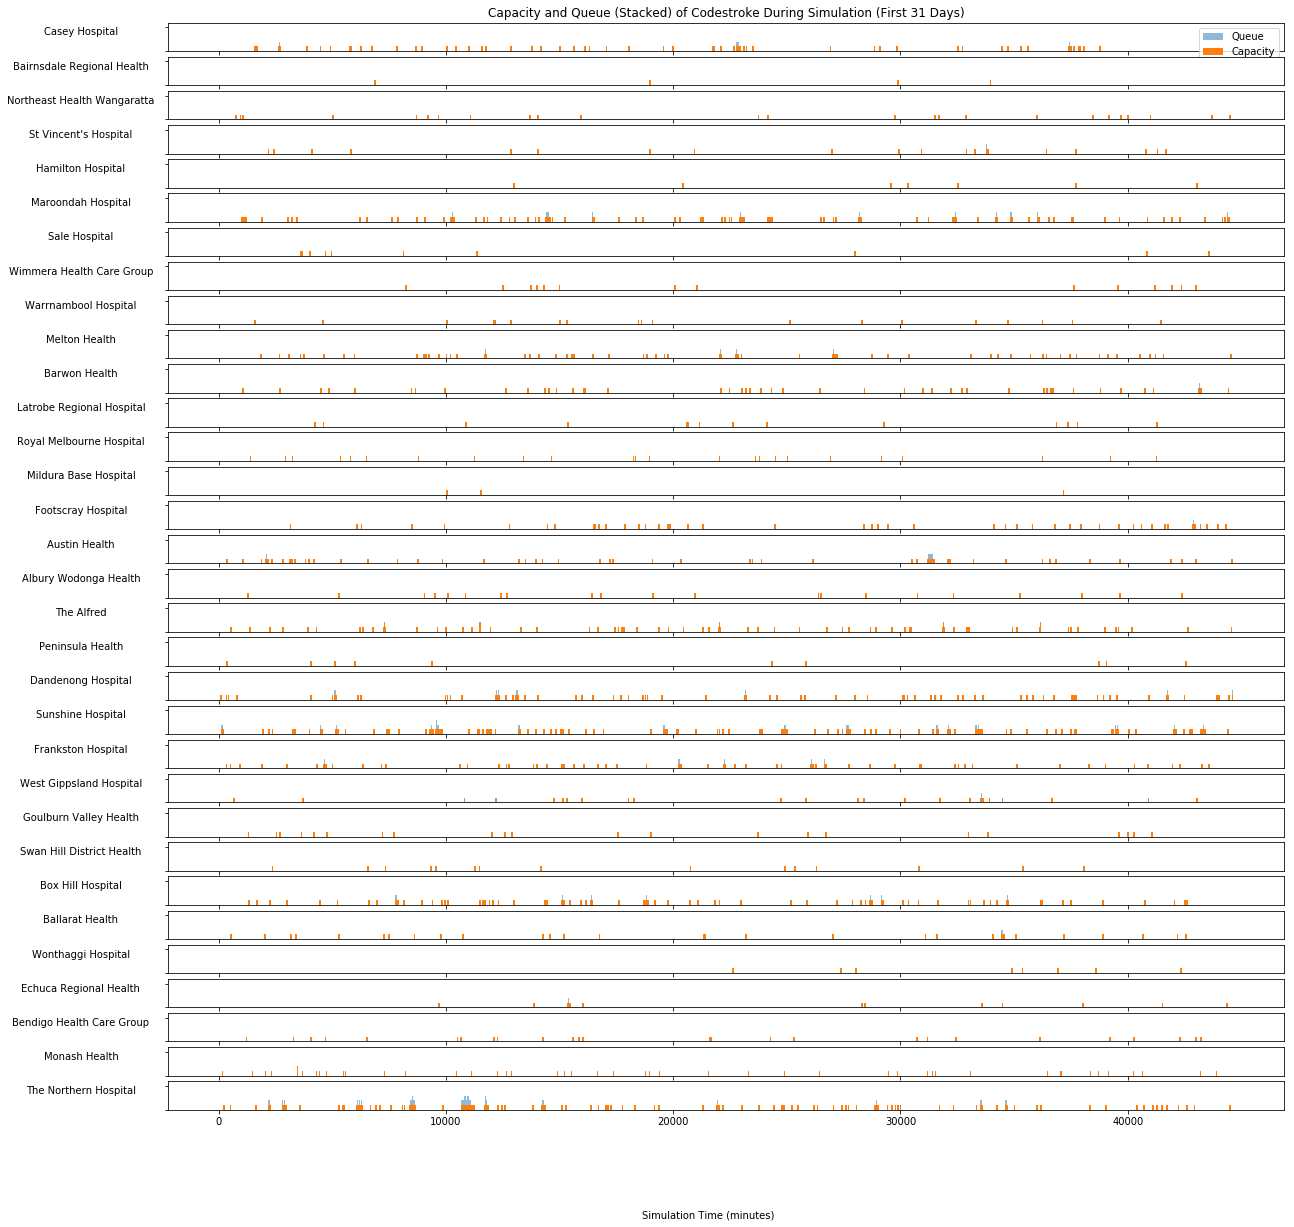

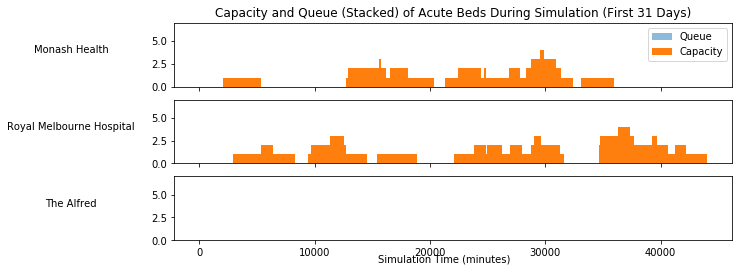

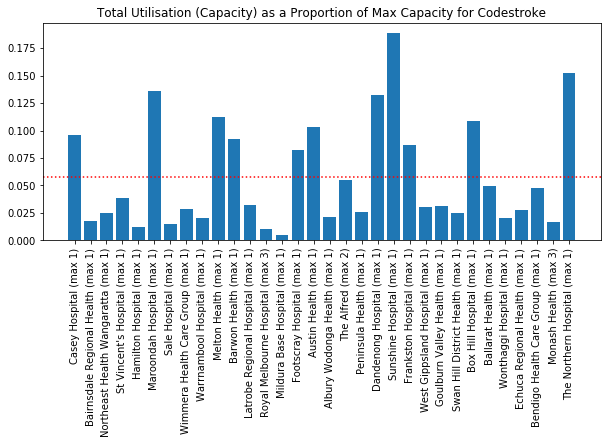

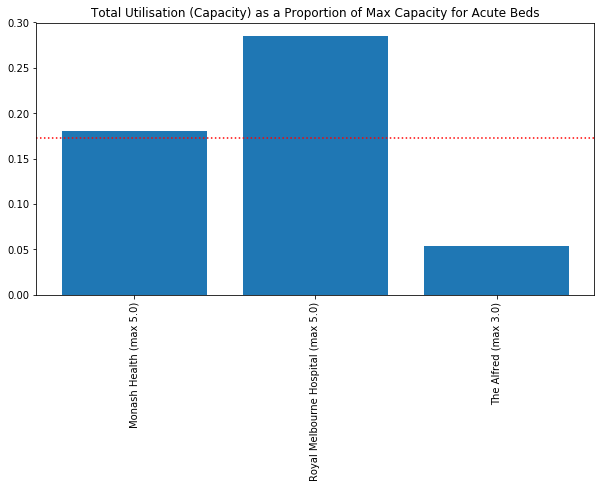

In [16]:
hospital_usage_file = "data/processed/2019_06_30_0112_3_2hosp_vicsim_codestroke_usage.csv"
angio_usage_file = "data/processed/2019_06_30_0112_3_2hosp_vicsim_acutebed_usage.csv"
make_plots(hospital_usage_file, angio_usage_file)

### ECR 5

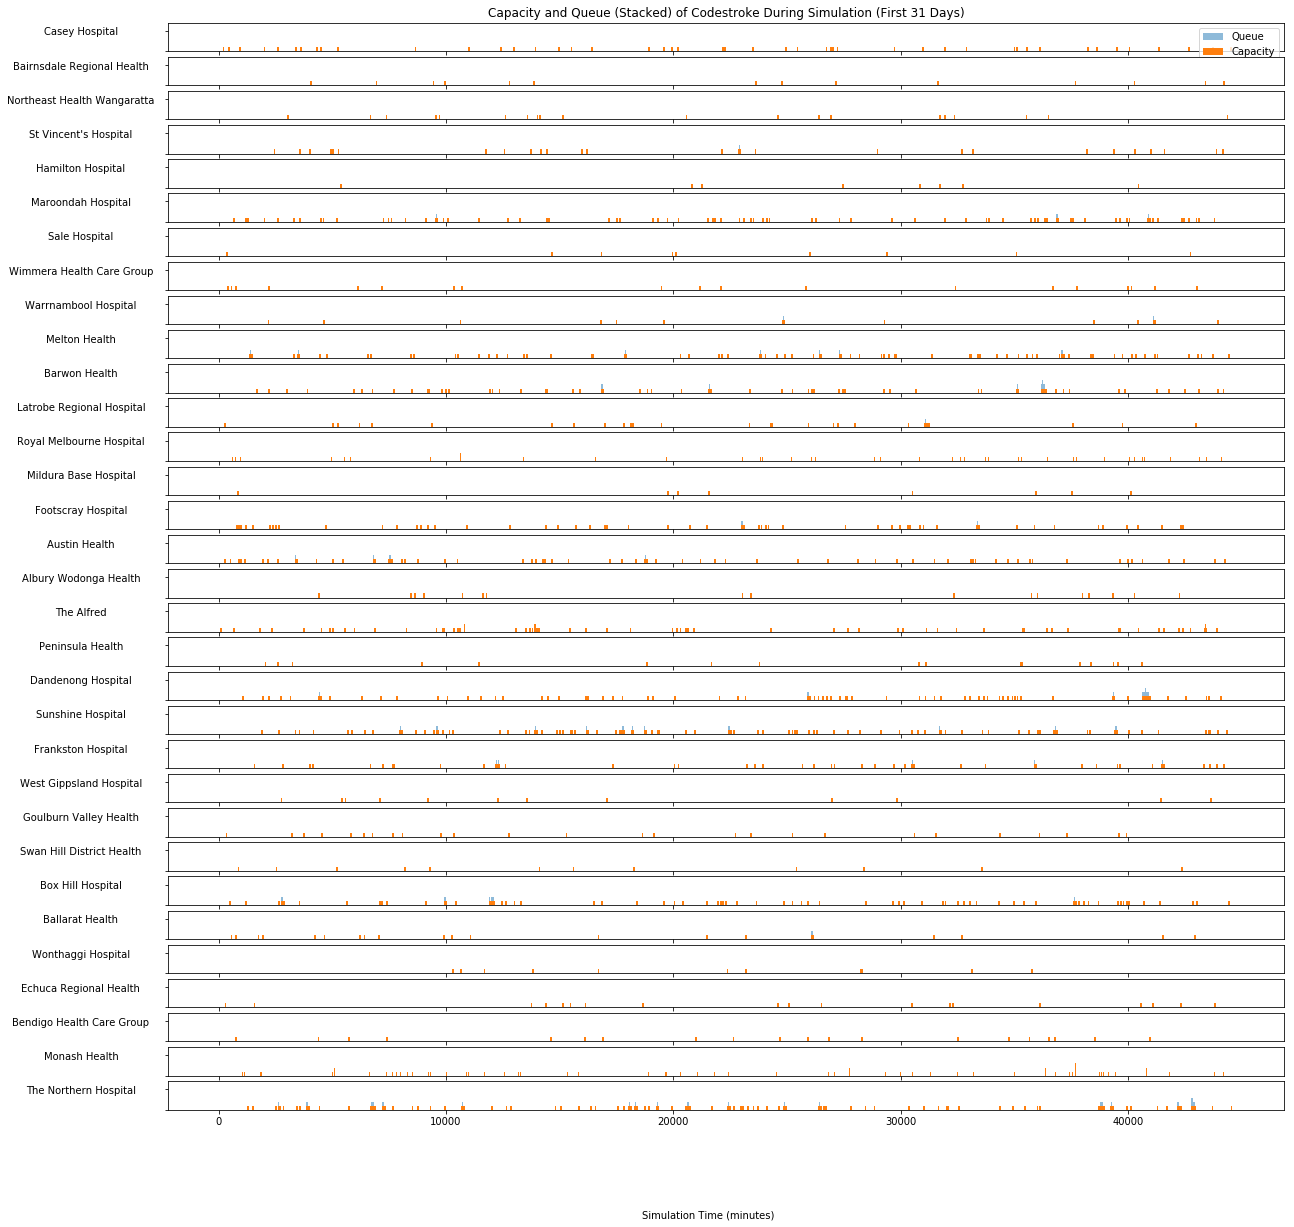

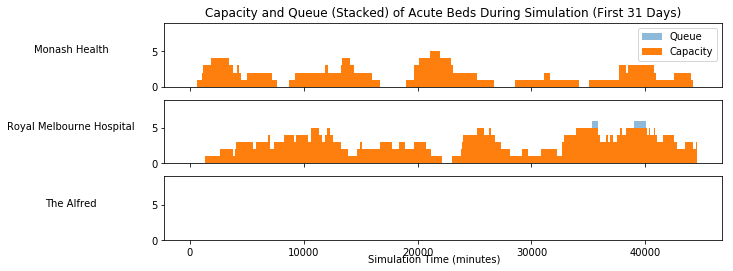

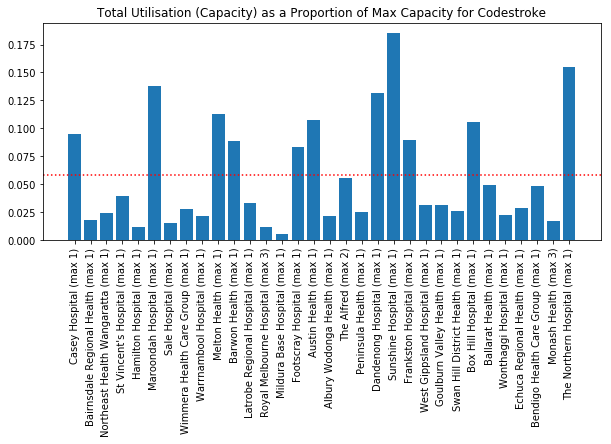

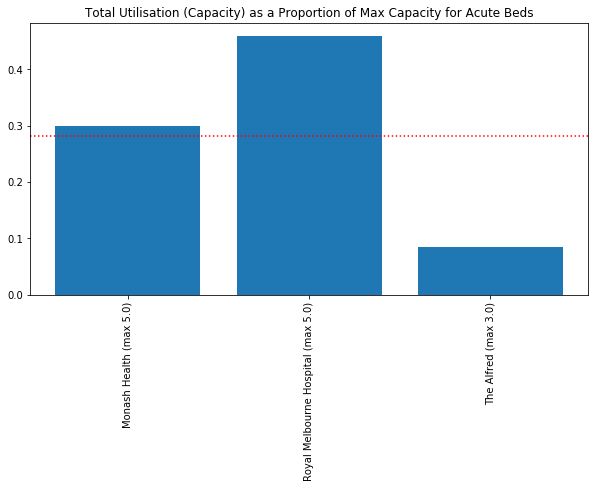

In [17]:
hospital_usage_file = "data/processed/2019_06_30_0117_5_2hosp_vicsim_codestroke_usage.csv"
angio_usage_file = "data/processed/2019_06_30_0117_5_2hosp_vicsim_acutebed_usage.csv"
make_plots(hospital_usage_file, angio_usage_file)

### ECR 10

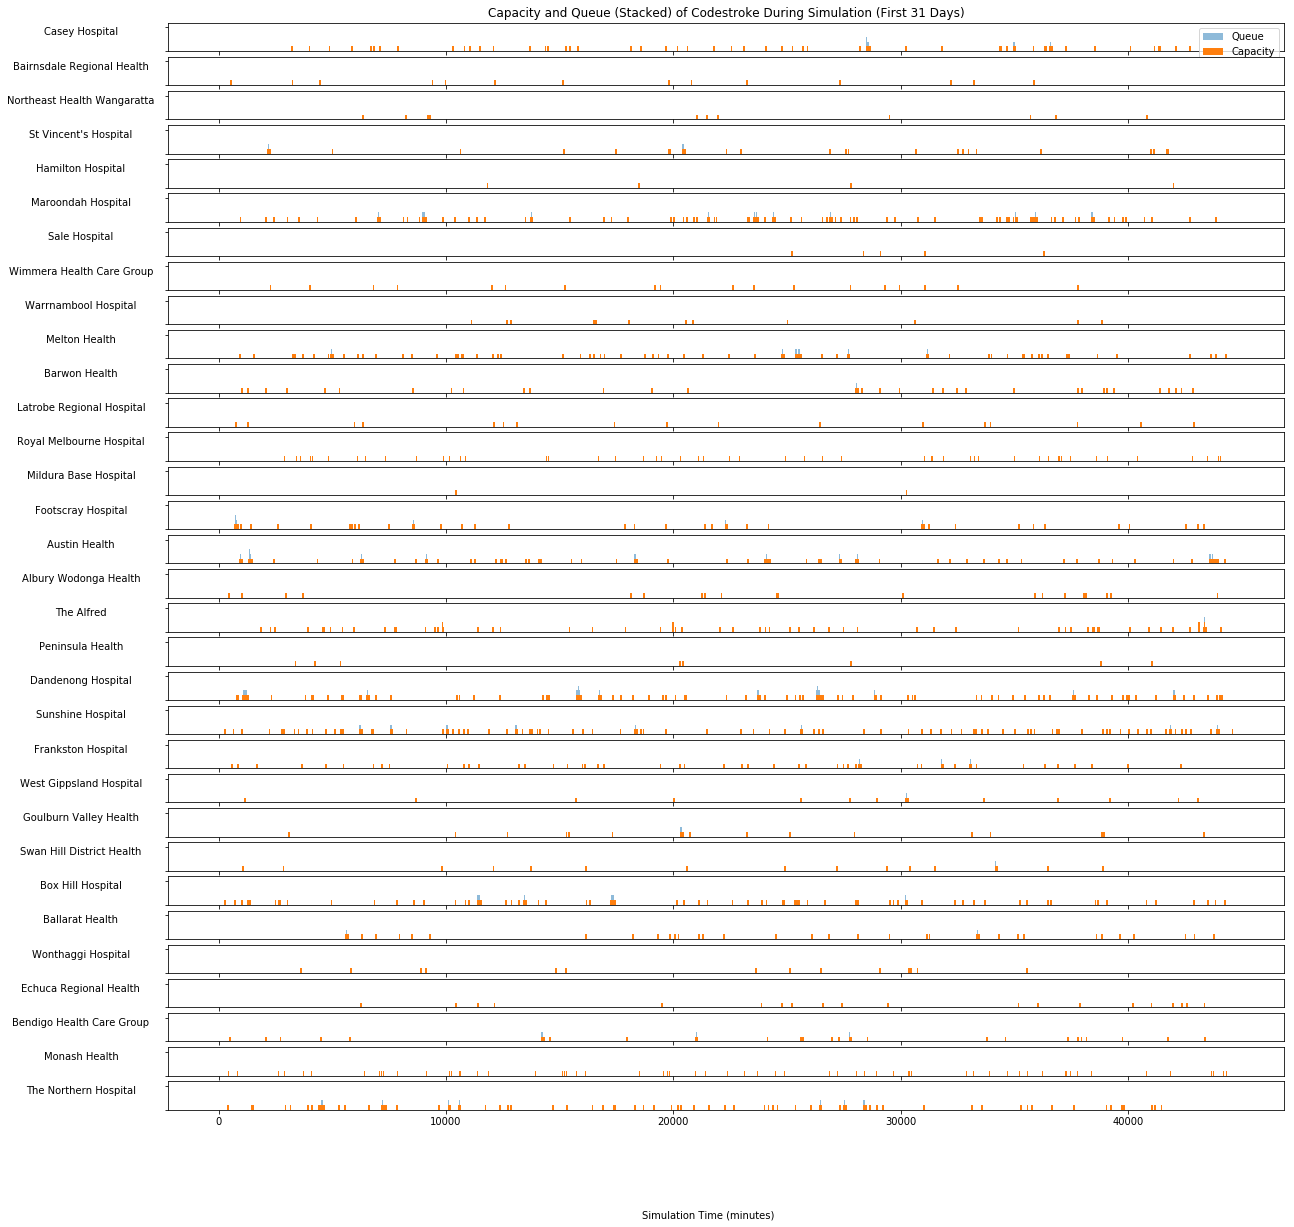

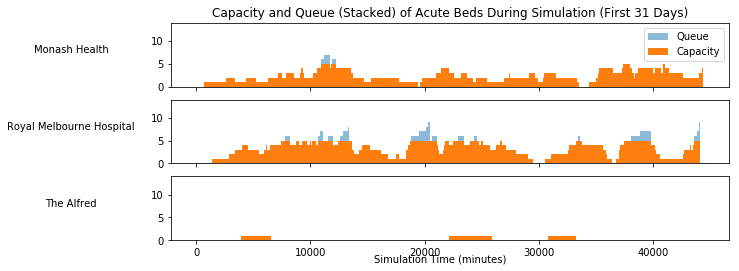

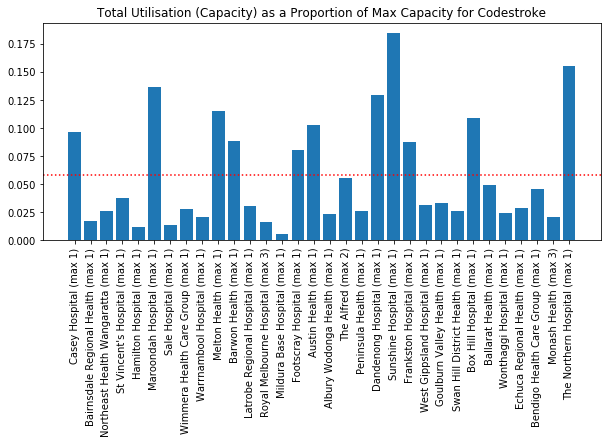

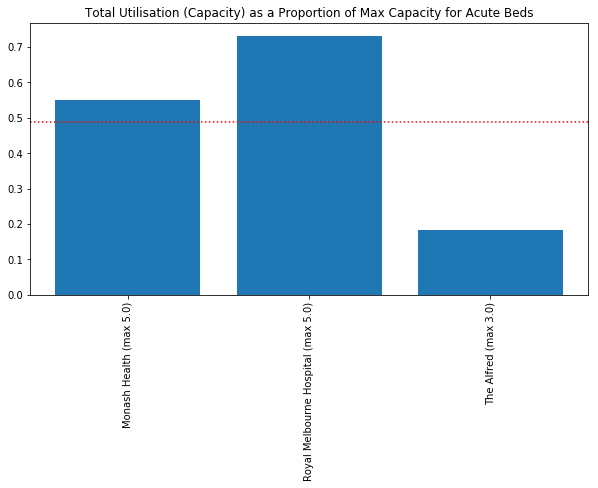

In [18]:
hospital_usage_file = "data/processed/2019_06_30_0123_10_2hosp_vicsim_codestroke_usage.csv"
angio_usage_file = "data/processed/2019_06_30_0123_10_2hosp_vicsim_acutebed_usage.csv"
make_plots(hospital_usage_file, angio_usage_file)

### ECR 15

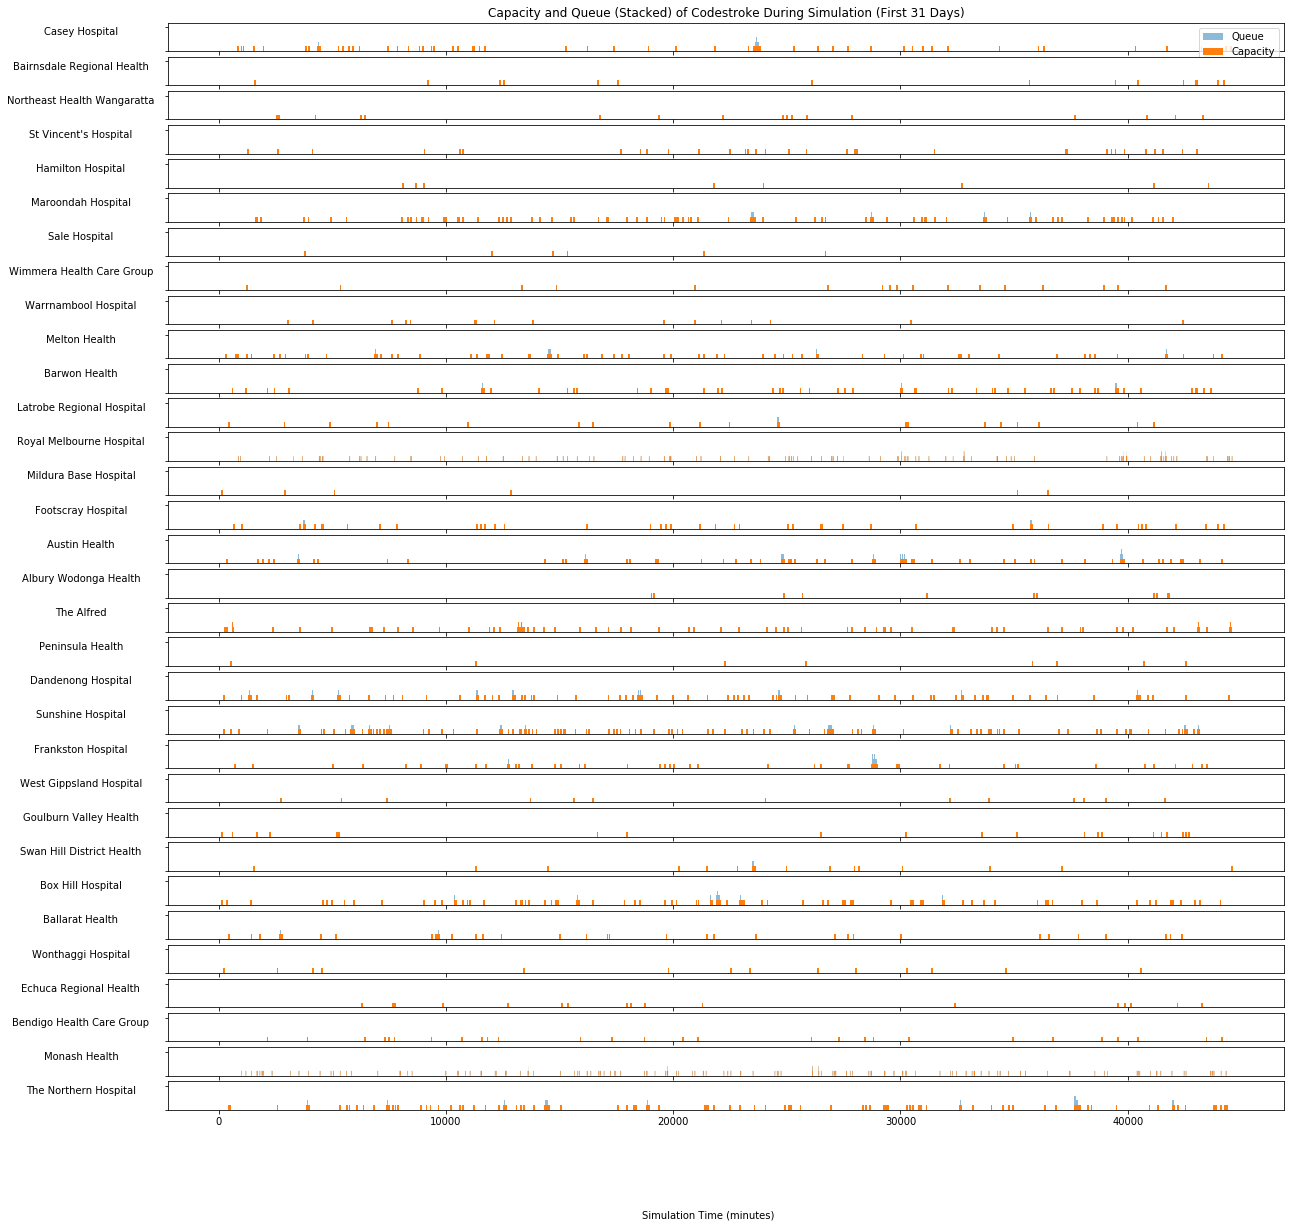

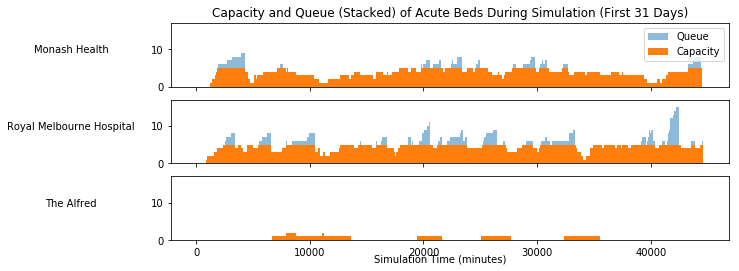

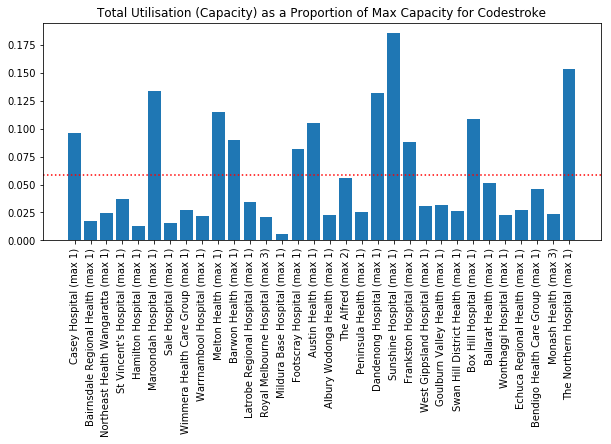

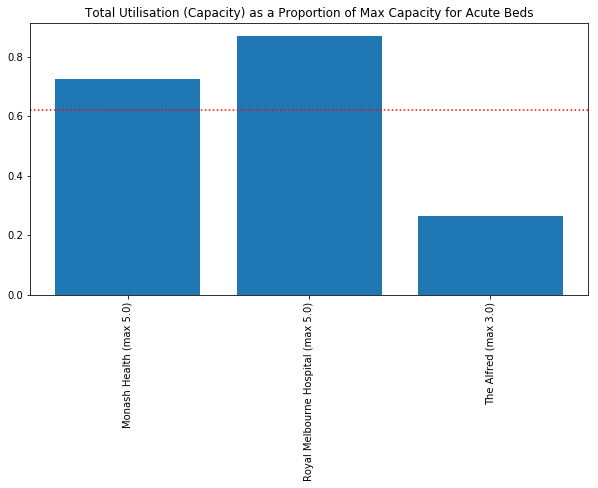

In [19]:
hospital_usage_file = "data/processed/2019_06_30_0128_15_2hosp_vicsim_codestroke_usage.csv"
angio_usage_file = "data/processed/2019_06_30_0128_15_2hosp_vicsim_acutebed_usage.csv"
make_plots(hospital_usage_file, angio_usage_file)